In [1]:
import os
import shutil

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import combinations

In [2]:
hr_level_0 = pd.read_csv('../data/interim/hr_level_0.csv')
hr_level_1 = pd.read_csv('../data/interim/hr_level_1.csv')

articles = pd.read_csv('../data/interim/articles.csv')
articles.head()

,id,hr_level_0,hr_level_1,hr_level_2,hr_level_3,hr_level_4,publication,time,title,snippet,text
0,0,0,0,NaN,152.0,NaN,Финмаркет,2018-03-29T14:13:00,В этом году на льготные автокредиты и лизинг б...,FINMARKET.RU - Премьер России Дмитрий Медведев...,В этом году на льготные автокредиты и лизинг б...
1,1,0,0,NaN,152.0,NaN,ТАСС,2018-03-29T14:16:00,Медведев: около 50 тыс. машин продадут в 2018 ...,Около 50 тыс. автомашин будет продано в текуще...,Около 50 тыс. автомашин будет продано в текуще...
2,2,0,0,NaN,152.0,NaN,Российская газета,2018-03-29T14:30:00,Кабмин выделит 7 миллиардов рублей на льготное...,Правительство выделяет 7 миллиардов рублей на ...,Названы ставки по ипотеке и автокредитам в 201...
3,3,0,0,NaN,152.0,NaN,Телеканал 360°,2018-03-29T14:43:00,Правительство РФ выделит порядка 7 млрд на льг...,Из указанной суммы около семи миллиардов напра...,Правительством России предусмотрено свыше 12 м...
4,4,0,0,NaN,152.0,NaN,Интерфакс,2018-03-29T15:38:00,Правительство выделит в 2018 г. около 7 млрд р...,Правительство РФ выделит в 2018 году около 7 м...,Правительство РФ выделит в 2018 году около 7 м...


### Ручное построение иерархие

#### Структура иерархии

* **hr_level_0** - уровень разбивающий новости на категории: Политика, Спорт и т.д.
* **hr_level_1** - уровень подкатигорий
* **hr_level_2** - уровень масштабных событий, растянутых во времени, или экономических, политических и т.п. явлений
* **hr_level_3** - уровень точечных событий
* **hr_level_4** - уровень развития, уточнений, различных мнений и т.п. связанных с одним точечным событием

#### 0-ой уровень иерархии

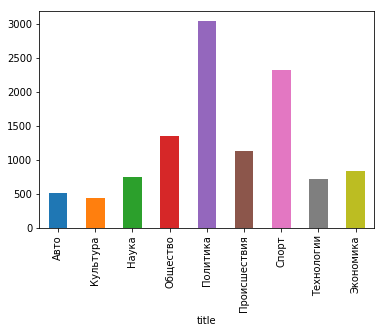

In [3]:
data = articles.groupby(['hr_level_0']).id.count()
data.index = hr_level_0.title

data.plot.bar()

#### 1-ый уровень иерархии

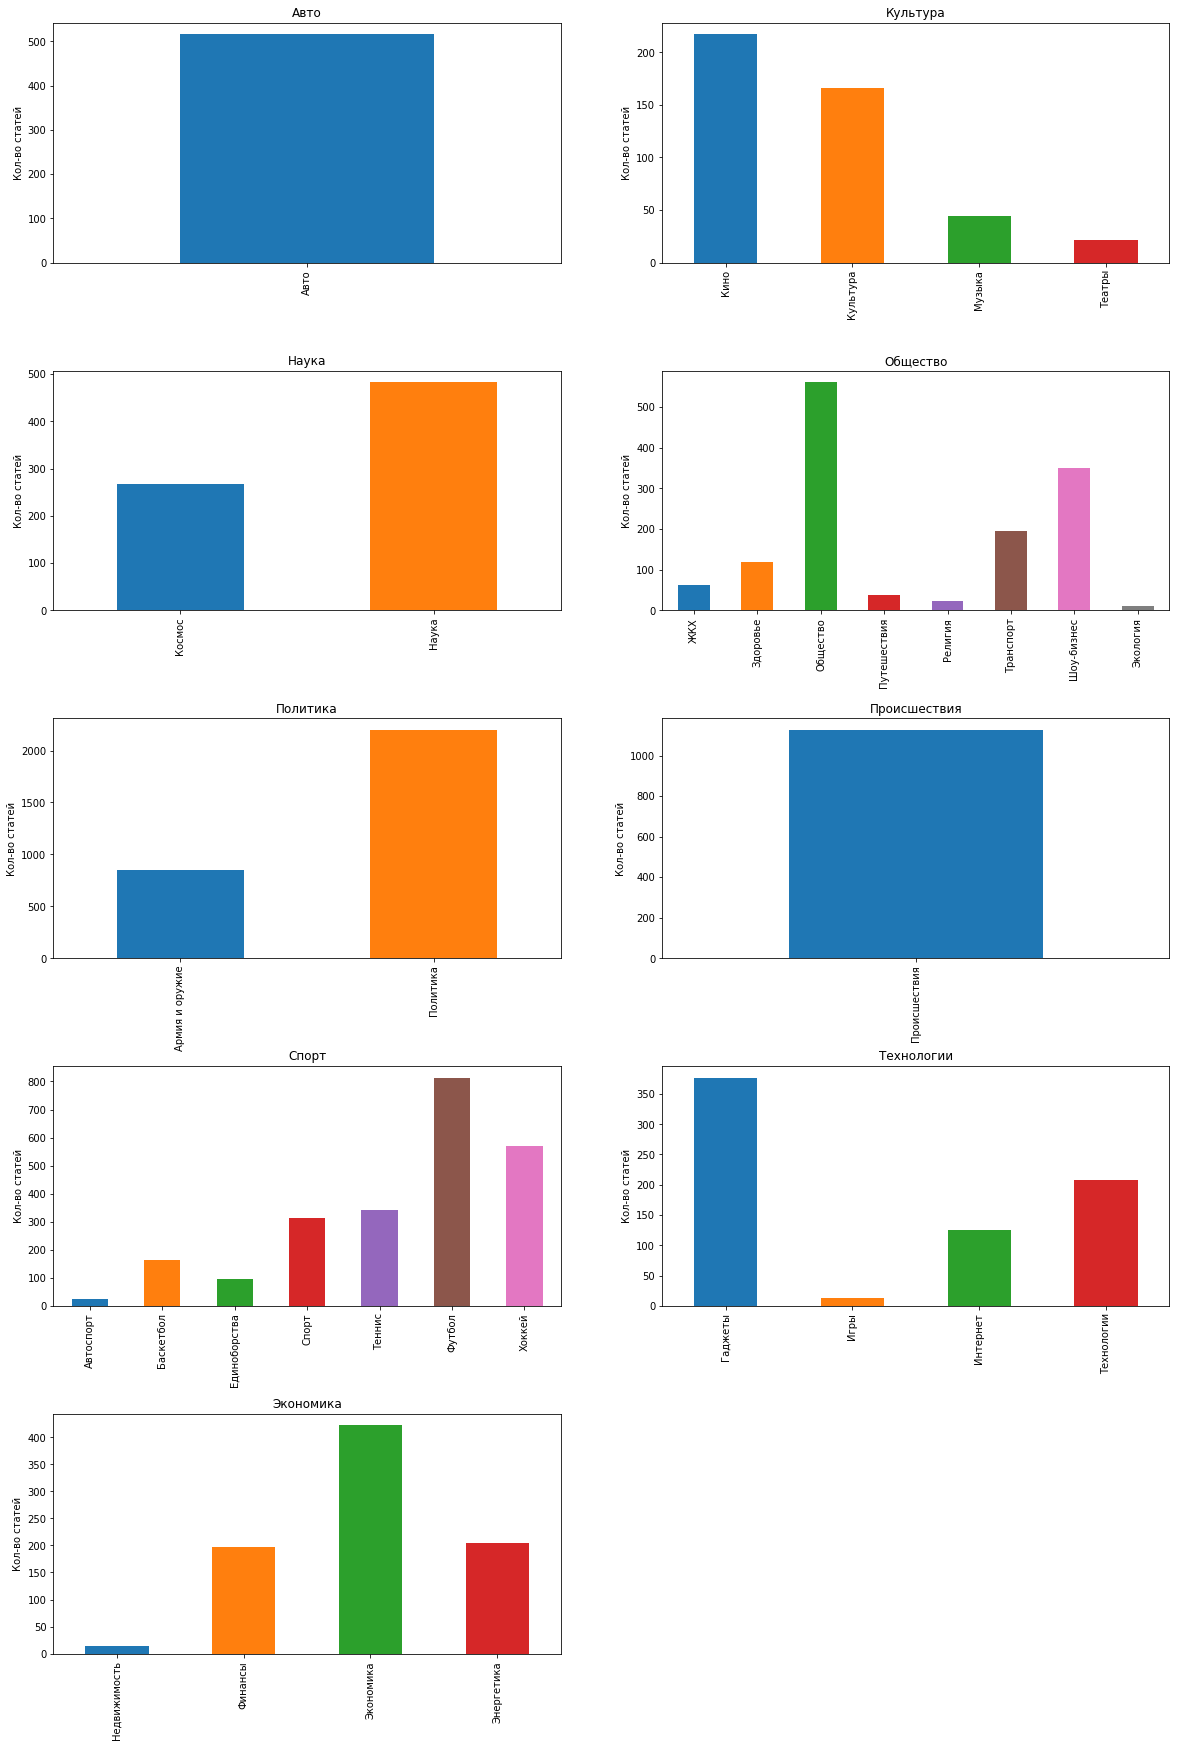

In [4]:
plt.figure(figsize=(20, 30))

for index, title in enumerate(hr_level_0.title, 1):

    level_0_id = hr_level_0[hr_level_0.title == title].id.values[0]

    data = articles[articles.hr_level_0 == level_0_id].groupby('hr_level_1').id.count()
    data.index = [hr_level_1[hr_level_1.id == index].title.values[0] for index in data.index]
    
    plt.subplot(520+index)
    plt.title(title)
    data.plot.bar()
    plt.subplots_adjust(hspace = 0.45)
    plt.ylabel('Кол-во статей')
    
plt.show()

#### Сохранение тем сгруппированных по 1-ому уровню для ручной разметки

In [5]:
level_1_groups_path = '../data/interim/level_1_groups'
#os.mkdir(level_1_groups_path)

for group_id, group in articles.groupby('hr_level_1'):
    
    group_name = hr_level_1[hr_level_1.id == group_id].iloc[0].title
    group_path = os.path.join(level_1_groups_path, group_name)
    
    shutil.rmtree(group_path, ignore_errors=True)
    os.mkdir(group_path)
    
    for level_4_group_id, level_4_group in group.groupby('hr_level_3'):
        
        level_4_group = level_4_group.sort_values('time')
        level_4_group = '\n'.join([f'{article.id}\t{article.time}\t{article.title}\n\n{article.text}\n\n'
                                   for _, article in level_4_group.iterrows()])
        with open(os.path.join(group_path, str(level_4_group_id)+'.txt'), 'w') as fl:
            fl.write(level_4_group)

#### Замечания

На данный момент мной размеченны категории: Авто, Культура, Наука, Технологии, Экономика. 

**Замечание 1.** Если кажется, что подкатегория у документа проставлена не правильно, то можно смело перемещать. Часто бывало, что новости об одном событии разбросаны по разным категориям. Между категориями мне кажется лучше не тусовать, а то запутаемся.

**Замечание 2.** Не нужно стремиться заполнить все пустоты в таблицы. Вполне нормально, что событие не объединяется с другими в какое-то маштабное, или не имееет резонанса, развития или разных точек зрения на него. Таким образом, 3-ий уровень есть почти всегда, а 2-ого и 4-ого может и не быть проставлено для документа.

**Замечание 3.** Если имеющиеся темы на третьем уровне оказались слишком мелко раздроблены (несколько тем об одном и том же точечном событии), то объединяем их присваивая наименьший номер, объединяемых событий.

**Замечание 4.** Так как нумеровать темы на 2-ом и 4-ом уровне нужно самим, то предлагаю следующую схему:

    Пусть n - номер темы на уровень выше, m - порядковый номер нумеруемой тобой темы в данной теме на уровень выше. 
    
    Тогда текущий номер n_m. (Кажется это позволит нам не пересечься?)


#### Авто

In [6]:
#АВТО 0
#АВТО 0

#Автосалон в Нью-Йорке
articles.loc[articles.hr_level_3.isin([153, 154, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 168, 216]), 'hr_level_2'] = '0_0'

#157 Subaru Forester 2019
#появление фото
articles.loc[articles.id.isin([48, 49, 50]), 'hr_level_4'] = '157_0'
#дебьт на выставке
articles.loc[articles.id.isin([51, 52, 53]), 'hr_level_4'] = '157_1'

#164 Toyota RAV4
#появление фото
articles.loc[articles.id.isin([92, 93, 94, 95, 96, 99, 103]), 'hr_level_4'] = '164_0'
#дебьт на выставке
articles.loc[articles.id.isin([97, 98, 100, 101, 102, 104, 105, 106, 107, 108]), 'hr_level_4'] = '164_1'

#### Культура

In [7]:
#КУЛЬТУРА 1

#КИНО 10
#1082 Александр Митта отмечает 85-летие
#Поздравиления Медведева
articles.loc[articles.id.isin([9508, 9509, 9510, 9511]), 'hr_level_4'] = '1082_0'

#МУЗЫКА 13

#1096 памятник Дэвиду Боуи
#Установили памятник
articles.loc[articles.id.isin([9600, 9601]), 'hr_level_4'] = '1096_0'
#Памятник пострадал от вандалов
articles.loc[articles.id.isin([9602, 9603, 9604, 9599, 9605, 9606, 9607, 9608]), 'hr_level_4'] = '1096_1'

#1099 скандал в паре Ильи Яббарова и Алёны Савкиной
#Илья Яббаров записал для Алены Савкиной песню
articles.loc[articles.id.isin([9623, 9621]), 'hr_level_4'] = '1099_0'

#КУЛЬТУРА 12

#Смерть Анофриева
#522, 534, 356 перенести в Культура/Культура
articles.loc[articles.hr_level_3.isin([356, 522, 534]), 'hr_level_0'] = 1
articles.loc[articles.hr_level_3.isin([356, 522, 534]), 'hr_level_1'] = 12
#356, 522, 534, 1055, 1057, 1058, 1069 объединяем в одну тему на третьем уровне
articles.loc[articles.hr_level_3.isin([356, 522, 534, 1055, 1057, 1058, 1069]), 'hr_level_3'] = 356
#Констатация смерти и описание жизни
articles.loc[articles.id.isin([9269, 9270, 9271, 9274, 9278, 9279, 9281, 9284, 9285, 9294, 9322, 9329, 9331, 9385]), 'hr_level_4'] = '356_0'
#Стас Садальский высказался об Олеге Анофриеве
articles.loc[articles.id.isin([9273, 9277, 9283]), 'hr_level_4'] = '356_1'
#Пост о смерти Анофриева появился в Instagram Олешко
articles.loc[articles.id.isin([9275, 9276, 9317, 9318, 9319, 9321, 9323, 9324, 9325, 9326, 9328, 9330]), 'hr_level_4'] = '356_2'
#Cемья сообщила о причине смерти
articles.loc[articles.id.isin([9280, 9282, 9286, 9287, 9288, 9289, 9268, 9290, 9291, 9292, 9293, 9320]), 'hr_level_4'] = '356_3'
#Прощание с Олегом Анофриевым пройдет 30 марта в Центральной клинической больнице
articles.loc[articles.id.isin([9298, 9299, 9300, 9301, 9302, 9303, 9304, 9305, 9306, 9307, 
                               9308, 9309, 9310, 9311, 9312, 9313, 9314, 9315, 9316, 3735, 3757]), 'hr_level_4'] = '356_4'
#Олега Анофриева похоронят на Аксиньинском кладбище в Подмосковье
articles.loc[articles.id.isin([3736, 3737, 3738, 3739, 3740, 3741, 3742, 3743, 3744, 3745, 3746, 
                               3747, 3748, 3749, 3750, 3751, 3734, 3752, 3753, 3754, 3755, 3756]), 'hr_level_4'] = '356_5'
#В Москве завершилась церемония прощания с Олегом Анофриевым
articles.loc[articles.id.isin([3758, 3759, 3760, 3761, 3762, 3763, 3764]), 'hr_level_4'] = '356_6'
#Мединский соболезнует родным Олега Анофриева
articles.loc[articles.id.isin([9386, 9387]), 'hr_level_4'] = '356_7'
#Путин соболезнует родным Олега Анофриева
articles.loc[articles.id.isin([9389, 9390, 9391, 9392, 9393, 9394, 9395, 9396, 9397, 9398, 9399, 9400, 9402, 9401, 9384, 9403, 9405, 9406]), 'hr_level_4'] = '356_8'
#Медведев соболезнует родным Олега Анофриева
articles.loc[articles.id.isin([9407, 9408, 9409, 9410]), 'hr_level_4'] = '356_9'
#Ярмольник рассказал об Анофриеве
articles.loc[articles.id.isin([4841, 4842, 4843]), 'hr_level_4'] = '356_10'
#Гафт назвал Анофриева замечательным человеком с хорошим юмором
articles.loc[articles.id.isin([4766, 4767, 4768, 4769, 4770, 4771, 4772, 4773]), 'hr_level_4'] = '356_11'

#### Наука

In [8]:
#НАУКА 2

#КОСМОС 11

#Падение космической станции «Тяньгун-1»
#1182, 1184, 1187 объединяем в одну тему на третьем уровне
articles.loc[articles.hr_level_3.isin([1182, 1184, 1187]), 'hr_level_3'] = 1182
#Астрономы засняли падающую китайскую космическую станцию
articles.loc[articles.id.isin([10185, 10186, 10187]), 'hr_level_4'] = '1182_0'
#Ускорила вращение и начала быстро приближаться к Земле
articles.loc[articles.id.isin([10192, 10191, 10193, 10194, 10195, 10196, 10197, 10198]), 'hr_level_4'] = '1182_1' 
#Китай предупредил о скором падении
articles.loc[articles.id.isin([10215, 10216, 10217, 10218, 10219, 10220, 10221, 10222, 
                               10223, 10224, 10225, 10226, 10227, 10228, 10214, 10229, 10230]), 'hr_level_4'] = '1182_2'

#1186 Выход астронавтов НАСА в открытый космос
#Перенесли из-за проверки скафандров
articles.loc[articles.id.isin([10208, 10209, 10207]), 'hr_level_4'] = '1186_0'
#Установили на МКС новое оборудование
articles.loc[articles.id.isin([10211, 10212, 10213]), 'hr_level_4'] = '1186_1' 

#### Технологии

In [9]:
#ТЕХНОЛОГИИ 7

#ИНТЕРНЕТ 9

#Утечка данных из Facebook
#414 перенести в Технологии
articles.loc[articles.hr_level_3.isin([414]), 'hr_level_0'] = 7
#414, 1228, 1257 перенести в Интернет
articles.loc[articles.hr_level_3.isin([414, 1228, 1257]), 'hr_level_1'] = 9
#414, 1228, 1257, 1297, 1300, 1305 объединяем в одну на втором уровне
articles.loc[articles.hr_level_3.isin([414, 1228, 1257, 1297, 1300, 1305]), 'hr_level_2'] = '9_0'
#1228, 1297 объединяем в одну на третьем уровне
#Прекращение сотрудничества с информационными брокерами
articles.loc[articles.hr_level_3.isin([1228, 1297]), 'hr_level_3'] = 1228
#1300, 1305 объединяем в одну на третьем уровне
#Предоставление пользователям новые средства контроля конфиденциальности
articles.loc[articles.hr_level_3.isin([1300, 1305]), 'hr_level_3'] = 1300

#1298 обновление приложения VK
#iOS
articles.loc[articles.id.isin([11037, 11039, 11040, 11041]), 'hr_level_4'] = '1298_0'

#В работе Telegram произошел глобальный сбой
#1219, 1221, 1222, 1232, 1234 нужно перенеси в Интернет
articles.loc[articles.hr_level_3.isin([1219, 1221, 1222, 1232, 1234]), 'hr_level_1'] = 9
#Объединяем в одну тему на третьем уровне
articles.loc[articles.hr_level_3.isin([1219, 1221, 1222, 1232, 1234, 1294, 1296]), 'hr_level_3'] = 1219
#Произошел масштабный сбой
articles.loc[articles.id.isin([10554, 10555, 10556, 10557, 10558, 10559, 10560, 10561, 10564, 10565, 10989, 10990, 10991, 10992, 10993]), 'hr_level_4'] = '1219_0'
#Пользователи предпочли WhatsApp во время сбоя Telegram
articles.loc[articles.id.isin([10405, 10406, 10404, 10407, 10408]), 'hr_level_4'] = '1219_1'
#Мошенники заработали на сбое Telegram
articles.loc[articles.id.isin([10414, 10415, 10416, 10417, 10418, 10419, 10420, 10421, 10422, 10423, 10424]), 'hr_level_4'] = '1219_2'
#Комментарии Дурова
articles.loc[articles.id.isin([10425, 10426, 10427, 10428, 10429, 10430, 10432, 10438, 10439, 
                               10440, 10441, 10442, 10443, 10444, 10445, 10446, 10447, 10448, 
                               10449, 10450, 10451, 10452, 10453, 10454, 10455, 10456, 10457, 10458]), 'hr_level_4'] = '1219_3'
#Работа мессенджера восстановлена
articles.loc[articles.id.isin([10431, 10433, 10435, 10436, 10562, 10563, 10566, 11004, 11005, 
                               11006, 11007, 11008, 11009, 11010, 11011, 11012, 11014, 11013, 
                               11015, 11016, 11017, 11018, 11019, 11020, 11021, 11022, 11023, 11025]), 'hr_level_4'] = '1219_4'
#Эксперт объяснил причины сбоя
articles.loc[articles.id.isin([10434, 10437, 10545, 10546, 10547, 10548]), 'hr_level_4'] = '1219_5'

#ГАДЖЕТЫ 4

#Huawei представила флагманские смартфоны P20 и P20 Pro
#1262, 1270 объединяем в одну на третьем уровне
articles.loc[articles.hr_level_3.isin([1262, 1270]), 'hr_level_3'] = 1262

#Презентация новых продуктов Apple
#1285, 1286 объединяем в одну на третьем уровне
articles.loc[articles.hr_level_3.isin([1285, 1286]), 'hr_level_3'] = 1285
#Онлайн-магазин Apple перед презентацией закрылся
articles.loc[articles.id.isin([10963, 10964, 10965, 10961]), 'hr_level_4'] = '1285_0'
#В Чикаго Apple проведет традиционную весеннюю презентацию
articles.loc[articles.id.isin([10956, 10957, 10958, 10955, 10960]), 'hr_level_4'] = '1285_1'
#В Чикаго завершилась худшая презентация продуктов Apple
articles.loc[articles.id.isin([10959, 10962]), 'hr_level_4'] = '1285_2'

#### Экономика

In [10]:
#ЭКОНОМИКА 8

#ЭНЕРГЕТИКА 32

#«Лукойл» стал дороже «Роснефти»
#664, 668 объединяем на третьем уровне
articles.loc[articles.hr_level_3.isin([664, 668]), 'hr_level_3'] = 664
#Констатация факта
articles.loc[articles.id.isin([5707, 5708, 5709, 5710, 5711, 5712, 5713, 5714, 5715, 5716, 5717, 5718, 5719, 5720, 5721]), 'hr_level_4'] = '664_0'
#Коментарии экспертов
articles.loc[articles.id.isin([5734, 5733, 5735]), 'hr_level_4'] = '664_1'

#Сделка ОПЕК+
#660, 663 объединяем на третьем уровне
articles.loc[articles.hr_level_3.isin([660, 663]), 'hr_level_3'] = 660
#Россия и ОПЕК готовят беспрецедентную сделку
articles.loc[articles.id.isin([5698, 5699, 5700, 5701, 5702, 5703, 5704, 5705, 5706, 5697]), 'hr_level_4'] = '660_0'
#Глава Минэнерго Новак отметил позитивную роль соглашения ОПЕК+
articles.loc[articles.id.isin([5661, 5662, 5663, 5660]), 'hr_level_4'] = '660_1'

#Взысканию долга с российского «Газпрома» в пользу «Нафтогаза»
#559 перенести в Энергетику
articles.loc[articles.hr_level_3.isin([559]), 'hr_level_1'] = 32
#559, 656, 659 объединяем на третьем уровне
articles.loc[articles.hr_level_3.isin([559, 656, 659]), 'hr_level_3'] = 559
#«Газпром» отразит в отчете выплаты «Нафтогазу» по решению Стокгольмского суда
articles.loc[articles.id.isin([5605, 5606, 5607, 5608, 5611, 5631]), 'hr_level_4'] = '559_0'
#Нафтогаз издевательски назвал Газпром «котиками»
articles.loc[articles.id.isin([5609, 5610, 5612, 5613, 5614, 5615, 5616, 5617, 5618, 5619, 
                               5620, 5621, 5622, 5623, 5624, 5625, 5626, 5627, 5628, 5629, 5630]), 'hr_level_4'] = '559_1'
#Украина готовится к принудительному взысканию
articles.loc[articles.id.isin([5654, 5655, 5656, 5657, 5658, 5659]), 'hr_level_4'] = '559_2'
#«Нафтогаз» уже в апреле может начать взыскание долга с «Газпрома»
articles.loc[articles.id.isin([4956, 4957, 4958, 4959, 4961, 4962, 4963, 4955, 4966, 4968, 4969, 4971, 4972, 4973]), 'hr_level_4'] = '559_3'
#«Нафтогаз» ждет от «Газпрома» добровольной выплаты долга
articles.loc[articles.id.isin([4960, 4964, 4965, 4967, 4970]), 'hr_level_4'] = '559_4'

#Риск роста цен на бензин до 5 руб. на литр и дефицит бензина
#655, 657 объединяем на третьем уровне
articles.loc[articles.hr_level_3.isin([655, 657]), 'hr_level_3'] = 655
#Трейдеры предупредили о риске роста цен на бензин до 5 руб. на литр\
articles.loc[articles.id.isin([5632, 5633, 5634, 5635, 5636, 5637, 5638, 5639, 5640, 5641, 5642, 5643, 5644]), 'hr_level_4'] = '655_0'
#ФАС не видит дефицита бензина в РФ, готовит штрафы при необоснованном росте цен
articles.loc[articles.id.isin([5587, 5588, 5589, 5590, 5591, 5592, 5593, 5594, 5595, 5645, 
                               5586, 5596, 5597, 5598, 5599, 5600, 5601, 5602, 5603, 5604]), 'hr_level_4'] = '655_1'

#Цены на бензин
articles.loc[articles.hr_level_3.isin([655, 672]), 'hr_level_2'] = '32_0'
articles.loc[articles.hr_level_3.isin([672]), 'hr_level_3'] = np.nan

#Цены на нефть
#648 перенести в Энергетику
articles.loc[articles.hr_level_3.isin([648]), 'hr_level_1'] = 32
articles.loc[articles.hr_level_3.isin([636, 648, 662, 665]), 'hr_level_2'] = '32_1'
articles.loc[articles.hr_level_3.isin([648, 662, 665]), 'hr_level_3'] = np.nan

#558, 577, 641 перенести в Энергетику
articles.loc[articles.hr_level_3.isin([558, 577, 641]), 'hr_level_1'] = 32

#ФИНАНСЫ 26

#610, 578, 594, 600 нужно перенести в Финансы
articles.loc[articles.hr_level_3.isin([610, 578, 594, 600]), 'hr_level_1'] = 26

#Курс валют
articles.loc[articles.hr_level_3.isin([617, 622, 631, 632, 637, 638, 640, 647]), 'hr_level_2'] = '26_0'
articles.loc[articles.hr_level_3.isin([617, 622, 631, 632, 637, 638, 640, 647]), 'hr_level_3'] = np.nan
#Взаимосвязь рубля и нефти
articles.loc[articles.id.isin([5408, 5409, 5410, 5411, 5412, 5413, 5414, 5467, 5468, 5469, 5470, 5466, 5471, 5517, 5516, 5518, 5526, 5527, 5525]), 'hr_level_3'] = '617'

#Рынок акций
articles.loc[articles.hr_level_3.isin([578, 610, 619, 630, 594, 600]), 'hr_level_2'] = '26_1'
#Биржи РФ 
articles.loc[articles.hr_level_3.isin([578, 619, 630]), 'hr_level_3'] = 578
#Биржи США
articles.loc[articles.hr_level_3.isin([594, 600]), 'hr_level_3'] = 594

#Индекс доверия потребителей
articles.loc[articles.hr_level_3.isin([620, 634, 651]), 'hr_level_2'] = '26_2'
#ФРГ
articles.loc[articles.id.isin([5491, 5490]), 'hr_level_3'] = '26_2_0'
#Британия
articles.loc[articles.id.isin([5492]), 'hr_level_3'] = '26_2_1'
#Южная Корея
articles.loc[articles.id.isin([5575]), 'hr_level_3'] = '26_2_2'
#Италия
articles.loc[articles.id.isin([5576, 5574]), 'hr_level_3'] = '26_2_3'

#Криптовалюта
articles.loc[articles.hr_level_3.isin([623, 628]), 'hr_level_2'] = '26_3'
articles.loc[articles.hr_level_3.isin([623, 628]), 'hr_level_3'] = np.nan

#Инфляция
articles.loc[articles.hr_level_3.isin([624]), 'hr_level_2'] = '26_4'
articles.loc[articles.hr_level_3.isin([624]), 'hr_level_3'] = np.nan

#Цены на золото
articles.loc[articles.hr_level_3.isin([646]), 'hr_level_2'] = '26_5'
articles.loc[articles.hr_level_3.isin([646]), 'hr_level_3'] = np.nan

#ЭКОНОМИКА 31

#Распространение страхования средств в банках на юрлиц
#563, 592 объединяем на третьем уровне
articles.loc[articles.hr_level_3.isin([563, 592]), 'hr_level_3'] = 563
#ЦБР за распространение страховки по вкладам на малый и средний бизнес, но не на всех юрлиц
articles.loc[articles.id.isin([5011, 5012, 5010, 5013, 5014]), 'hr_level_4'] = '563_0'
#АСВ предложило расширить систему страхования вкладов на все юрлица
articles.loc[articles.id.isin([5245, 5246, 5247]), 'hr_level_4'] = '563_1'

#Великобритания хочет запретить продажу российских бондов
#566, 565 объединяем в одну тему на третьем уровне
articles.loc[articles.hr_level_3.isin([566, 565]), 'hr_level_3'] = 565
#В Лондон предлагает ограничить обслуживание российских евробондов
articles.loc[articles.id.isin([5046, 5047, 5048, 5049, 5050, 5051, 5052, 5053, 5054, 5055, 5056, 5057, 5058, 
                               5059, 5060, 5061, 5062, 5063, 5064, 5065, 5066, 5067, 5068, 5069, 5070, 5071, 
                               5072, 5073, 5074, 5075, 5078, 5079, 5080, 5081, 5082, 5083, 5045, 5086, 5029, 5036]), 'hr_level_4'] = '565_0'
#Минфин прокомментировал возможный запрет на продажу российских долговых ценных бумаг в Лондоне
articles.loc[articles.id.isin([5025, 5026, 5027, 5028, 5085, 5030, 5031, 5032, 5033, 5034, 
                               5024, 5035, 5037, 5038, 5039, 5040, 5041, 5042, 5043, 5044]), 'hr_level_4'] = '565_1'

#### Происшедствия

In [11]:
#ПРОИСШЕДСТВИЯ 5

#ПРОИСШЕДСТВИЯ 18

#Дело Скрипаля
#413 перенести в Происшедствия/Происшедствия
articles.loc[articles.hr_level_3.isin([413]), 'hr_level_0'] = 5
articles.loc[articles.hr_level_3.isin([413]), 'hr_level_1'] = 18
#413 Друг Скрипаля заговорил о милосердии и предложил умертвить шпиона и его дочь
#413, 970, 983, 1003, 1033 объединяем в одну тему на третьем уровне
articles.loc[articles.hr_level_3.isin([413, 970, 983, 1003, 1033]), 'hr_level_2'] = '18_0'

#Пожар в «Зимней вишне»
#987, 1023 объединяем в одну тему на третьем уровне
articles.loc[articles.hr_level_3.isin([987, 1023]), 'hr_level_3'] = 987
#МЧС установило очаг возгорания в «Зимней вишне»
articles.loc[articles.id.isin([8564, 8565, 8566, 8567, 8568, 8569, 8570, 8571, 8563, 8572, 8573, 8574, 8575, 
                               8576, 8577, 8578, 8579, 8580, 8581, 8582, 8583, 8584, 8585, 8586, 8587]), 'hr_level_4'] = '987_0'
#Появилось новое жуткое видео
articles.loc[articles.id.isin([8971, 8972, 8973, 8974]), 'hr_level_4'] = '987_1'

#Автобус с российскими детьми в Берлине
#956, 958, 986 объединяем в одну тему на третьем уровне
articles.loc[articles.hr_level_3.isin([956, 958, 986]), 'hr_level_3'] = 956
#Остановили автобус с российскими детьми в Берлине
articles.loc[articles.id.isin([8140, 8141, 8142, 8143, 8144, 8145, 8146, 8147, 8148, 8149, 8150, 8151, 8152, 
                               8153, 8154, 8155, 8156, 8157, 8158, 8159, 8162, 8163, 8165, 8167, 8139, 8168]), 'hr_level_4'] = '956_0'
#Посольство РФ в ФРГ проясняет ситуацию
articles.loc[articles.id.isin([8160, 8161, 8164, 8166]), 'hr_level_4'] = '956_1'
#СК проверит инцидент
articles.loc[articles.id.isin([8169, 8170, 8171, 8552, 8553, 8554, 8555, 8556, 8557, 8558, 8559, 8551, 8560, 8561, 8562]), 'hr_level_4'] = '956_2'
#Задержанный в Германии разваливающийся автобус с российскими детьми прошел перед выездом все проверки
articles.loc[articles.id.isin([8202, 8203, 8204, 8201]), 'hr_level_4'] = '956_3'

#962 Uber временно запретили испытывать беспилотные автомобили
#Аризона
articles.loc[articles.id.isin([8243, 8244, 8245, 8246, 8247, 8248, 8249, 8250, 8251, 8252, 8253, 8254, 8257, 8242]), 'hr_level_4'] = '962_0'
#Калифорния
articles.loc[articles.id.isin([8255, 8256]), 'hr_level_4'] = '962_1'

#967 В несколько военных учреждений Вашингтона прислали пакеты со взрывчаткой
#сообщение факта
articles.loc[articles.id.isin([8291, 8292, 8293, 8294, 8295, 8296, 8297, 8298, 8299, 8300, 8301, 8302, 
                               8303, 8304, 8305, 8306, 8307, 8308, 8309, 8310, 8312]), 'hr_level_4'] = '967_0'
#приступник пойман
articles.loc[articles.id.isin([8311, 8313, 8290, 8314, 8315]), 'hr_level_4'] = '967_1'

#в США неизвестный водитель умышленно наехал на людей, есть погибшие
#963, 969 объединяем в одну тему на третьем уровне
articles.loc[articles.hr_level_3.isin([963, 969]), 'hr_level_3'] = 963

#975 В Техасе преступник расстрелял людей и скрылся
#сообщение факта
articles.loc[articles.id.isin([8387, 8388, 8389, 8390, 8391, 8392, 8393]), 'hr_level_4'] = '975_0'
#приступник пойман
articles.loc[articles.id.isin([8394, 8395]), 'hr_level_4'] = '975_1'

#999 вербовщик ИГ в Петербурге
#отказался от показаний
articles.loc[articles.id.isin([8716, 8717, 8718, 8719, 8721]), 'hr_level_4'] = '999_0'
#получил 15 лет колонии
articles.loc[articles.id.isin([8723, 8724, 8725, 8726, 8727, 8728, 8729, 8730, 8731, 8732, 8733, 8715, 8734, 8735]), 'hr_level_4'] = '999_1'

#1006 Подозреваемый по делу о взрыве газа в Мурманске
#умер в больнице
articles.loc[articles.id.isin([8772, 8773, 8774, 8775, 8776, 8777, 8778, 8779, 8780, 8781, 8782, 8783, 
                               8784, 8785, 8786, 8787, 8788, 8789, 8790, 8791, 8794, 8795, 8799]), 'hr_level_4'] = '1006_0'
#находился под действием наркотиков
articles.loc[articles.id.isin([8792, 8793, 8796, 8797, 8798]), 'hr_level_4'] = '1006_1'

#1016 задохнулись угарным газом
#Три человека найдены мертвыми в квартире в Прикамье
articles.loc[articles.id.isin([8895, 8896, 8897, 8898, 8899, 8900, 8901, 8902, 8903, 8904, 8909]), 'hr_level_4'] = '1016_0'
#Число жертв отравления газом в жилом доме в Прикамье увеличилось до пяти
articles.loc[articles.id.isin([8905, 8906, 8907, 8908, 8910, 8911, 8912, 8913, 8914, 8915, 8916]), 'hr_level_4'] = '1016_1'

#1021 В ДЛТ на Большой Конюшенной произошел пожар
#произошел пожар
articles.loc[articles.id.isin([8943, 8944, 8945, 8946, 8947, 8948, 8950, 8954, 8955, 8957, 8959, 8961, 8962, 8963]), 'hr_level_4'] = '1021_0'
#Стала известна причина пожара
articles.loc[articles.id.isin([8952, 8951, 8953, 8956, 8958, 8960]), 'hr_level_4'] = '1021_0'

#1030 пожар в Ульяновске
#загорелось двухэтажное здание
articles.loc[articles.id.isin([9009, 9010, 9011, 9012, 9013, 9014, 9015, 9016, 9020]), 'hr_level_4'] = '1030_0'
#потушили пожар на трикотажной фабрике
articles.loc[articles.id.isin([9017, 9018]), 'hr_level_4'] = '1030_1'
#произошел от искры во время сварочных работ
articles.loc[articles.id.isin([9021, 9022]), 'hr_level_4'] = '1030_2'

#361 На полигоне «Ядрово» в Волоколамске зафиксирован очередной выброс
#361 перенести в Происшедствия
articles.loc[articles.hr_level_3.isin([361]), 'hr_level_0'] = 5
articles.loc[articles.hr_level_3.isin([361]), 'hr_level_1'] = 18

#### Общество

In [12]:
#ОБЩЕСТВО 3

#ОБЩЕСТВО 16

#349 олимпиада по астрономии
#Школьник из Тобольска стал призером Всероссийской олимпиады по астрономии
articles.loc[articles.id.isin([3679, 3680]), 'hr_level_4'] = '349_0'
#Собянин отметил успехи московских школьников на Всероссийской олимпиаде по астрономии
articles.loc[articles.id.isin([3681, 3678, 3682]), 'hr_level_4'] = '349_1'

#388 Дополнительные выплаты
articles.loc[articles.hr_level_3.isin([388]), 'hr_level_2'] = '16_0'
#Мособлдума приняла закон о единовременной денежной выплате жителям Подмосковья старше 70 лет
articles.loc[articles.id.isin([3977, 3979, 3980, 3983]), 'hr_level_3'] = '16_0_0'
#Дополнительную выплату будут предоставлять подмосковным семьям, воспитывающих детей-инвалидов
articles.loc[articles.id.isin([3978, 3981, 3982, 3984, 3985, 3986, 3987]), 'hr_level_3'] = '16_0_1'

#396 Тотальный диктант
articles.loc[articles.hr_level_3.isin([396]), 'hr_level_2'] = '16_1'
articles.loc[articles.hr_level_3.isin([396]), 'hr_level_3'] = np.nan

#ЗДОРОВЬЕ 7

#482, 487 Волоколамск, Яровое, осмотр детей
articles.loc[articles.hr_level_3.isin([482, 487]), 'hr_level_3'] = 482
#Пробы воды возьмут во всех школах Волоколамска
articles.loc[articles.id.isin([4527, 4529, 4531]), 'hr_level_4'] = '482_0'
#детей ежедневно осматривают медики в Волоколамске
articles.loc[articles.id.isin([4528, 4530, 4532, 4533, 4534, 4582, 4583, 4584]), 'hr_level_4'] = '482_1'

#Эпидемия гриппа
articles.loc[articles.hr_level_3.isin([473, 476, 477, 478, 479, 486]), 'hr_level_2'] = '7_0'
#В Орске продлили весенние каникулы
articles.loc[articles.id.isin([4484]), 'hr_level_3'] = '7_0_0'
#В петербургских школах продлили весенние каникулы
articles.loc[articles.id.isin([4468, 4469, 4470, 4471, 4472, 4473, 4474, 4475, 4467, 4476, 4477, 4478, 4479, 4480, 4481, 4482, 4483, 4485]), 'hr_level_3'] = '7_0_1'
#Каникулы для школьников Пензы продлены из-за эпидемии гриппа и ОРВИ
articles.loc[articles.id.isin([4493]), 'hr_level_3'] = '7_0_2'
#Воронежским школьникам продлили каникулы из-за вспышки гриппа
articles.loc[articles.id.isin([4494, 4495]), 'hr_level_3'] = '7_0_3'

#ТРАНСПОРТ 25

#346 переносим из Общества в Транспорт
articles.loc[articles.hr_level_3.isin([346]), 'hr_level_1'] = 25

#448 развод мостов в Петербурге
articles.loc[articles.hr_level_3.isin([448]), 'hr_level_2'] = '25_0'
#Ночью 28 марта
articles.loc[articles.id.isin([4334, 4335, 4336]), 'hr_level_3'] = '25_0_0'
#Ночью 29 марта
articles.loc[articles.id.isin([4337, 4338]), 'hr_level_3'] = '25_0_1'
#Ночью 30 марта
articles.loc[articles.id.isin([4339, 4340, 4341, 4342]), 'hr_level_3'] = '25_0_2'

#Движение поездов
articles.loc[articles.hr_level_3.isin([1046]), 'hr_level_0'] = 3
articles.loc[articles.hr_level_3.isin([1046]), 'hr_level_1'] = 25
articles.loc[articles.hr_level_3.isin([1046]), 'hr_level_2'] = '25_1'
#На «оранжевой» линии метро
articles.loc[articles.id.isin([9172, 9173, 9174, 9177, 9178, 9179, 9175, 9176]), 'hr_level_3'] = '25_1_0'
#сбой
articles.loc[articles.id.isin([9172, 9173, 9174, 9177, 9178, 9179]), 'hr_level_4'] = '25_1_0_0'
#движение востановленно
articles.loc[articles.id.isin([9175, 9176]), 'hr_level_4'] = '25_1_0_1'
#На «салатовой» линии метро
articles.loc[articles.id.isin([9180, 9181, 9182, 9183, 9184, 9185, 9186, 9188, 9189, 9192, 9196, 9200, 9201, 
                               9190, 9194, 9195, 9197, 9203, 9204, 9187, 9191, 9193, 9198, 9199, 9202]), 'hr_level_3'] = '25_1_1'
#сбой
articles.loc[articles.id.isin([9180, 9181, 9182, 9183, 9184, 9185, 9186, 9188, 9189, 9192, 9196, 9200, 9201, 9187, 9191, 9193, 9198]), 'hr_level_4'] = '25_1_1_0'
#движение востановленно
articles.loc[articles.id.isin([9190, 9194, 9195, 9197, 9203, 9204, 9199, 9202]), 'hr_level_4'] = '25_1_1_1'

#459 закрытия участка «фиолетовой» линии метро
#чай
articles.loc[articles.id.isin([4406, 4407]), 'hr_level_4'] = '459_0'
#Пассажиропоток
articles.loc[articles.id.isin([4408, 4409]), 'hr_level_4'] = '459_1'

#ШОУ-БИЗНЕС 29
#499 Владимиру Преснякову исполнилось 50 лет
#Кристина Орбакайте поблагодарила Преснякова за сына
articles.loc[articles.id.isin([4649, 4650, 4651, 4652, 4653, 4654, 4655]), 'hr_level_4'] = '499_0'

#### Спорт

In [13]:
# Автоспорт

# команды Формулы 1

#объединяем в одну тему на третьем уровне
topics_level_3 = [230, 231, 232, 233, 234, 235, 236]
articles.loc[articles.hr_level_3.isin(topics_level_3), 'hr_level_3'] = 230


#Документы в этой теме разбиваются на:

# новый пилот развития «Хааса»
articles.loc[articles.id.isin([515, 517, 518]), 'hr_level_4'] = '230_0'

# В Бахрейне гонщики „Феррари“ будут очень быстры
articles.loc[articles.id.isin([520, 522, 523]), 'hr_level_4'] = '230_1'

# Хэмилтон выступал без поддержки Боттаса
articles.loc[articles.id.isin([519, 521]), 'hr_level_4'] = '230_2'

# отношения «Хааса» и «Феррари»
articles.loc[articles.id.isin([524, 525, 526, 527]), 'hr_level_4'] = '230_3'

# Монтойя выступит в гонке «24 часа Ле Мана»
articles.loc[articles.id.isin([528, 529, 530]), 'hr_level_4'] = '230_4'

# Проблемы с двигателем „Хонда“
articles.loc[articles.id.isin([531, 532]), 'hr_level_4'] = '230_5'

# «Торо Россо» борется с «Уильямсом» и «Форс Индия»
articles.loc[articles.id.isin([533]), 'hr_level_4'] = '230_6'

# Запрет квалификационных режимов работы моторов «Мерседес»
articles.loc[articles.id.isin([534, 535, 536]), 'hr_level_4'] = '230_7'

# Ошибка механика «Хааса» на пит-стопе
articles.loc[articles.id.isin([537, 538, 539, 540]), 'hr_level_4'] = '230_8'


#--------
# 237 - были в Автоспорт, нужно перенеси в Футбол
articles.loc[articles.hr_level_3.isin([237]), 'hr_level_1'] = 27

# матч со «Сток Сити»
articles_id = [541, 542, 543, 544]
# articles.loc[articles.id.isin(articles_id), 'hr_level_4'] = '230_8'

# Баскетбол

#Документы в этой теме разбиваются на:

# Нэш, Кидд и Хилл будут введены в Зал славы НБА
articles.loc[articles.id.isin([7477, 7478, 7479]), 'hr_level_4'] = '872_0'

# Клуб «Нижний Новгород» вылетел из Кубка Европы
articles.loc[articles.id.isin([7481, 7482, 7483, 7487]), 'hr_level_4'] = '873_0'

# Лукич про игру с «Умана Рейер»
articles.loc[articles.id.isin([7480, 7485]), 'hr_level_4'] = '873_1'

# Губанов про игру с «Умана Рейер»
articles.loc[articles.id.isin([7484, 7486]), 'hr_level_4'] = '873_2'


# Матч «Химки» — «Фенербахче»

# анонс Матча «Химки» — «Фенербахче»
articles.loc[articles.id.isin([7488, 7489, 7490, 7492, 7493]), 'hr_level_4'] = '874_0'

# Георгиос Барцокас: нужно преодолеть проблемы с травмированными игроками
articles.loc[articles.id.isin([7490, 7507, 7512]), 'hr_level_4'] = '874_1'

# «Химки» проиграли «Фенербахче»
articles.loc[articles.id.isin([7491, 7496, 7497, 7498, 7499, 7500, 7501, 7502, 7503, 7508, 7513, 7514]), 'hr_level_4'] = '874_2'

# Швед установил новый рекорд Евролиги
articles.loc[articles.id.isin([7494, 7495]), 'hr_level_4'] = '874_3'

# Желько Обрадович: Мы атаковали медленно
articles.loc[articles.id.isin([7504]), 'hr_level_4'] = '874_4'

# Павел Астахов: «Химки» достойно сыграли с «Фенербахче»
articles.loc[articles.id.isin([7505, 7509]), 'hr_level_4'] = '874_5'

# турецкие фанаты поддержали Кемерово
articles.loc[articles.id.isin([7506]), 'hr_level_4'] = '874_6'

# Вячеслав Зайцев: Тренеру нашему тяжело, когда столько травмированных
articles.loc[articles.id.isin([7510]), 'hr_level_4'] = '874_7'

# Энтони Гилл: Наша команда получила урок
articles.loc[articles.id.isin([7511]), 'hr_level_4'] = '874_8'


# Л. Джеймс повторил рекорд М. Джордана
articles.loc[articles.id.isin([7515, 7516, 7517, 7518]), 'hr_level_4'] = '875_0'

# Джеймс о рекорде
articles.loc[articles.id.isin([7519]), 'hr_level_4'] = '875_1'

# Таунс установил рекорд «Миннесоты», набрав 56 очков
articles.loc[articles.id.isin([7520, 7521, 7522, 7523, 7524]), 'hr_level_4'] = '876_0'

# Таунс: делал всё ради победы
articles.loc[articles.id.isin([7525]), 'hr_level_4'] = '876_1'

#объединяем в одну тему на третьем уровне
topics_level_3 = [877, 883]
articles.loc[articles.hr_level_3.isin(topics_level_3), 'hr_level_3'] = 877

# «Лейкерс» вырвали победу над «Далласом»
articles.loc[articles.id.isin([7526, 7529]), 'hr_level_4'] = '877_0'

# Айзея Томас пропустит концовку сезона из-за операции на бедре
articles.loc[articles.id.isin([7527, 7548, 7549, 7550, 7551, 7552, 7553]), 'hr_level_4'] = '877_1'

# Ингрэм вернётся в строй
articles.loc[articles.id.isin([7528]), 'hr_level_4'] = '877_2'



# «Орландо» уступил «Бруклину»
articles.loc[articles.id.isin([7530, 7531, 7532, 7533]), 'hr_level_4'] = '878_0'

# Уокер вышел на первое место самых результативных игроков «Шарлотт»
articles.loc[articles.id.isin([7534, 7535, 7536]), 'hr_level_4'] = '879_0'

# Майкл Джордан: горжусь, что Кемба Уокер выступает за «Шарлотт»
articles.loc[articles.id.isin([7534]), 'hr_level_4'] = '879_1'

# состоится матч между «Ютой Джаз» и «Бостон Селтикс»
articles.loc[articles.id.isin([7538]), 'hr_level_4'] = '880_0'

# «Бостон» вырвал победу у «Юты» в матче НБА
articles.loc[articles.id.isin([7537, 7539, 7540]), 'hr_level_4'] = '880_1'

# Эмбиид был госпитализирован после матча с «Нью-Йорком»
articles.loc[articles.id.isin([7541, 7542, 7543, 7544]), 'hr_level_4'] = '881_0'

# 41 очко Джеймса принесло «Кливленду» победу над «Шарлотт»
articles.loc[articles.id.isin([7545, 7546, 7547]), 'hr_level_4'] = '882_0'

# «Голден Стэйт» проиграл «Индиане», «Клипперс» победили «Милуоки»
articles.loc[articles.id.isin([7554]), 'hr_level_4'] = '884_0'

# Дюрант примет участие в матче с «Милуоки»
articles.loc[articles.id.isin([7555, 7556]), 'hr_level_4'] = '884_1'

# «Милуоки» нанес «Голден Стэйт» третье поражение подряд
articles.loc[articles.id.isin([7557, 7558]), 'hr_level_4'] = '884_2'


# Дюрант повторил рекорд по количеству удалений за сезон
articles.loc[articles.id.isin([7559, 7560]), 'hr_level_4'] = '884_3'

# Дюрант: приношу извинения, хотя нет
articles.loc[articles.id.isin([7561]), 'hr_level_4'] = '884_4'

# Арбитр Кеннеди: Дюрант получил технические фолы
articles.loc[articles.id.isin([7562]), 'hr_level_4'] = '884_5'

# Керр: Дюрант сказал арбитрам волшебное слово
articles.loc[articles.id.isin([7563]), 'hr_level_4'] = '884_6'

# Адетокунбо: в «Милуоки» были довольны
articles.loc[articles.id.isin([7564]), 'hr_level_4'] = '884_7'

# Игуодала получил травму колена
articles.loc[articles.id.isin([7565]), 'hr_level_4'] = '884_8'

# У Лава подозрение на сотрясение мозга
articles.loc[articles.id.isin([7566, 7567, 7568, 7569, 7570, 7571]), 'hr_level_4'] = '885_0'

# «Индиана» победила «Голден Стэйт»
articles.loc[articles.id.isin([7572, 7573]), 'hr_level_4'] = '886_0'

# Оладипо: защита придала «Индиане» импульс для победы 
articles.loc[articles.id.isin([7574]), 'hr_level_4'] = '886_1'

# Макмиллан: «Индиана» нашла способ победить «Голден Стэйт»
articles.loc[articles.id.isin([7575]), 'hr_level_4'] = '886_2'

# Евгений Колесеников: «УНИКС хочет выиграть весь турнир»
articles.loc[articles.id.isin([7576]), 'hr_level_4'] = '887_0'

# «Химки» — УНИКС, ЦСКА - «Енисей»
topics_level_3 = [887, 890]
articles.loc[articles.hr_level_3.isin(topics_level_3), 'hr_level_3'] = 887

# Фото с матча «Химки» — УНИКС
articles.loc[articles.id.isin([7577]), 'hr_level_4'] = '887_1'

# Казанский УНИКС вырвал победу у «Химок»
articles.loc[articles.id.isin([7578, 7592, 7593, 7594, 7595, 7596, 7597, 7598, 7600]), 'hr_level_4'] = '887_2'

# ЦСКА дома победил «Енисей»
articles.loc[articles.id.isin([7588, 7590, 7591]), 'hr_level_4'] = '887_3'

# Аналитики: «Химки» прервут серию УНИКСа из восьми побед
articles.loc[articles.id.isin([7589]), 'hr_level_4'] = '887_4'


# Баскетболистка Завьялова назвала защитника ЦСКА Родригеса своим любимым разыгрывающим
articles.loc[articles.id.isin([7579, 7582]), 'hr_level_4'] = '888_0'

# Баскетболистка Завьялова: никому не отдам своего места в сборной России
articles.loc[articles.id.isin([7580]), 'hr_level_4'] = '888_1'

# Баскетболистка Завьялова: Ланге - очень сильный тренер
articles.loc[articles.id.isin([7581]), 'hr_level_4'] = '888_2'

# Баскетболистка сборной России вспомнила победу на молодежном чемпионате мира
articles.loc[articles.id.isin([7583, 7584]), 'hr_level_4'] = '888_3'

# «Финикс» потерпел 12-е поражение подряд
articles.loc[articles.id.isin([7585, 7586, 7587]), 'hr_level_4'] = '889_0'

# Леброн Джеймс набрал более 2000 очков за сезон
articles.loc[articles.id.isin([7604, 7606, 7601]), 'hr_level_4'] = '891_0'

# Джо Харрис: когда Леброн Джеймс пошёл на данк
articles.loc[articles.id.isin([7603, 7605]), 'hr_level_4'] = '891_1'

# «Кливленд» обыграл «Бруклин»
articles.loc[articles.id.isin([7602]), 'hr_level_4'] = '891_2'

# «Нижний Новгород» обыграл минский «Цмоки»
articles.loc[articles.id.isin([7607, 7608, 7609]), 'hr_level_4'] = '892_0'


# «Индиана» в овертайме обыграла «Майами»
articles.loc[articles.id.isin([7610, 7611, 7612]), 'hr_level_4'] = '893_0'

# «Филадельфия» вышла в плей-офф НБА
articles.loc[articles.id.isin([7613, 7614, 7615]), 'hr_level_4'] = '893_1'

# Макмиллан: «Индиана» не добилась бы таких успехов без Оладипо
articles.loc[articles.id.isin([7616]), 'hr_level_4'] = '893_2'

# «Хьюстон» переиграл «Атланту», Трипл-дабл Хардена
articles.loc[articles.id.isin([7617, 7618, 7619, 7620]), 'hr_level_4'] = '894_0'

# «Харден: 60 побед «Хьюстона» 
articles.loc[articles.id.isin([7621]), 'hr_level_4'] = '894_1'

# Эрик Гордон: нынешний сезон — особенный для «Хьюстона»
articles.loc[articles.id.isin([7622]), 'hr_level_4'] = '894_2'

# «Бостон» победил «Сакраменто»
articles.loc[articles.id.isin([7623, 7624, 7625]), 'hr_level_4'] = '895_0'

# Стивенс: «Бостон» выглядел здорово
articles.loc[articles.id.isin([7626]), 'hr_level_4'] = '895_1'

# Дабл-дабл Гобера помог «Юте» разгромить «Голден Стэйт»
articles.loc[articles.id.isin([7627, 7628]), 'hr_level_4'] = '896_0'

# Гобер: «Юта» готова взять у «Голден Стэйт» реванш
articles.loc[articles.id.isin([7629]), 'hr_level_4'] = '896_1'

# Керр: баскетболисты «Голден Стэйт» играют за себя и за того парня
articles.loc[articles.id.isin([7630]), 'hr_level_4'] = '896_2'

# «Клипперс» переиграли «Торонто»
articles.loc[articles.id.isin([7631, 7632]), 'hr_level_4'] = '897_0'

# Док Риверс: когда у тебя в команде есть Лу Уильямс, всё гораздо проще
articles.loc[articles.id.isin([7633]), 'hr_level_4'] = '897_1'

# «Портленд» победил «Оклахому»
articles.loc[articles.id.isin([7634, 7635, 7636]), 'hr_level_4'] = '898_0'

# В матче «Оклахома-Сити» - «Портленд» произошла массовая потасовка
articles.loc[articles.id.isin([7637, 7638]), 'hr_level_4'] = '898_1'


# Единоборства

# Прайс: мне всё равно, как я выиграю у Поветкина
articles.loc[articles.id.isin([7981, 7982, 7983, 7984, 7985, 7991, 7994, 7995]), 'hr_level_4'] = '937_0'

# Дэвид Прайс: Не буду переживать по поводу допинг-проб Поветкина
articles.loc[articles.id.isin([7986, 7990]), 'hr_level_4'] = '937_1'

# Поветкин заявил, что для него было бы честью провести бой против британца Джошуа
articles.loc[articles.id.isin([7988, 7989]), 'hr_level_4'] = '937_2'

# Поветкину остался один шаг до Джошуа
articles.loc[articles.id.isin([8003, 8004, 8007]), 'hr_level_4'] = '937_3'

# Поветкин и Прайс провели дуэль взглядов
articles.loc[articles.id.isin([7993, 7996]), 'hr_level_4'] = '937_4'

# Хирн: «Бой между Поветкиным и Джошуа состоится в 2018-м году»
articles.loc[articles.id.isin([7997, 7998, 7999, 8002]), 'hr_level_4'] = '937_5'

# Альваресу грозит годовое отстранение от боёв
articles.loc[articles.id.isin([8009, 8010, 8011]), 'hr_level_4'] = '938_0'

# Заседание комиссии по допинговому делу Альвареса перенесено
articles.loc[articles.id.isin([8012, 8008, 8013]), 'hr_level_4'] = '938_1'

# Мамиашвили: американцы совсем уже совесть потеряли
articles.loc[articles.id.isin([8015, 8016, 8017, 8019, 8020, 8014, 8023, 8024]), 'hr_level_4'] = '939_0'

# Михаил Мамиашвили: «Отказ в выдаче виз не отразится на отношениях борцов из России и США»
articles.loc[articles.id.isin([8016, 8021, 8022, 8026, 8027, 8028, 8029]), 'hr_level_4'] = '939_1'

# Абель Санчес: «Если Усик будет драться также, как с Бриедисом, бой будет коротким»
articles.loc[articles.id.isin([8032, 8033, 8034]), 'hr_level_4'] = '940_0'

# Нурмагомедов - Фергюсону: «Не понял твоего английского. Ты говоришь, как тупица»
articles.loc[articles.id.isin([8039, 8040, 8041, 8037, 8042, 8043, 8044]), 'hr_level_4'] = '941_0'

# Джошуа провёл открытую тренировку перед боем с Паркером
articles.loc[articles.id.isin([8050, 8051]), 'hr_level_4'] = '943_0'

# думаю, не будет Мейвезера-младшего в MMA (перенос в тему про Мейвезера)
articles.loc[articles.id.isin([8070]), 'hr_level_3'] = 944


# Спорт

# Фигуристка Медведева будет вести шоу «Ледниковый период. Дети»
articles.loc[articles.id.isin([5785, 5786, 5787, 5788, 5789, 5790, 5791, 5792,
                               5793, 5794, 5796, 5800, 5801, 5802, 5803, 
                               5804, 5807, 5808]), 'hr_level_4'] = '681_0'

# Татьяна Тарасова: «Мне нравится Медведева в шоу „Ледниковый период. Дети“»
articles.loc[articles.id.isin([5795, 5797, 5784]), 'hr_level_4'] = '681_1'

# Горшков: Медведева абсолютно точно не планирует завершать карьеру
articles.loc[articles.id.isin([5798, 5799, 5806]), 'hr_level_4'] = '681_2'


# Волейболистки казанского «Динамо» вышли в финал чемпионата России
articles.loc[articles.id.isin([5809, 5810, 5811, 5812, 5813, 5815, 5819]), 'hr_level_4'] = '682_0'

# Перепёлкин: казанское «Динамо» сыграло суперответственно в матче с «Уралочкой»
articles.loc[articles.id.isin([5816, 5817]), 'hr_level_4'] = '682_1'

# Инициатором отказа от грид-гёрлз стала жена коммерческого директора Формулы-1
# Было в теме Спорт, переносим в тему Автоспорт
articles.loc[articles.hr_level_3.isin([684]), 'hr_level_3'] = 1

# Логинов выиграл индивидуальную гонку на чемпионате России
articles.loc[articles.id.isin([5864, 5865, 5866, 5867, 5868, 5869, 
                               5870, 5872, 5873, 5874, 5875, 5876]), 'hr_level_4'] = '686_0'

# «Факел» уверено переиграл «Локомотив»
articles.loc[articles.id.isin([5882, 5883]), 'hr_level_4'] = '688_0'

# Тренер «Локомотива» Сёмин получил премию «Серебряная лань»
articles.loc[articles.id.isin([5888, 5889, 5890, 5891, 5893, 5895, 
                               5898, 5900, 5901, 5902, 5905, 5887]), 'hr_level_4'] = '689_0'

# Загитова, Медведева и Ласицкене получили премию «Серебряная лань»
articles.loc[articles.id.isin([5892, 5897, 5899, 5904, 5908]), 'hr_level_4'] = '689_1'

# Десять российских спортсменов получили награду «Серебряная лань»
articles.loc[articles.id.isin([5894, 5896, 5906, 5907]), 'hr_level_4'] = '689_2'


#объединяем в одну тему на третьем уровне
topics_level_3 = [939, 690]
# Было в теме Спорт, переносим в тему Единоборства
articles.loc[articles.hr_level_3.isin([690]), 'hr_level_3'] = 5
articles.loc[articles.hr_level_3.isin(topics_level_3), 'hr_level_3'] = 939


# В МИД России назвали дискриминацией невыдачу виз российским спортсменам
articles.loc[articles.id.isin([5910, 5911, 5912, 5913, 5914, 
                               5918, 5919, 5926, 5933]), 'hr_level_4'] = '939_2'

# Захарова прокомментировала невыдачу виз США
articles.loc[articles.id.isin([5916, 5920, 5930]), 'hr_level_4'] = '939_3'

# США отказали в визах российским борцам
articles.loc[articles.id.isin([5915, 5917, 5927, 5935, 5946, 5947, 
                               5948, 5949, 5950, 5909]), 'hr_level_4'] = '939_4'

# Федерация борьбы США рассчитывает, что россиян допустят до Кубка мира
articles.loc[articles.id.isin([5921, 5922, 5923, 5925, 5960]), 'hr_level_4'] = '939_5'

# Госдума: Невыдача виз США российским атлетам – удар по мировому спорту
articles.loc[articles.id.isin([5936, 5937, 5938, 5939, 5940, 5941, 5942, 5944]), 'hr_level_4'] = '939_6'

# Выяснилось, почему российские борцы не получили американские визы
articles.loc[articles.id.isin([5943, 5945, 5951, 5953, 5954]), 'hr_level_4'] = '939_7'

# Госдеп: Документы российских борцов на визы США всё ещё 
articles.loc[articles.id.isin([5957, 5958, 5959]), 'hr_level_4'] = '939_8'

# Биатлон
topics_level_3 = [686, 693]
articles.loc[articles.hr_level_3.isin(topics_level_3), 'hr_level_2'] = '21_0'

# Егорова выиграла индивидуальную гонку на чемпионате России
articles.loc[articles.id.isin([5981, 5983, 5984, 5985, 5986, 5987, 5988, 5989, 5991]), 'hr_level_4'] = '686_0'

# Допинг
# topics_level_3 = [687, 937, 938] - из единоборств
# articles.loc[articles.hr_level_3.isin(topics_level_3), 'hr_level_2'] = '21_1'

# Карякин сыграл вничью с Дин Лижэнем в последнем туре турнира претендентов
articles.loc[articles.id.isin([6002, 6003, 6004, 6005, 6006, 
                               6007, 6008, 6009, 6010, 6011, 
                               6012, 6023, 6024, 6035]), 'hr_level_4'] = '696_0'

# Каруана стал победителем турнира претендентов
articles.loc[articles.id.isin([6013, 6014, 6015, 6016, 6017, 
                               6018, 6021, 6022, 6026, 6036, 
                               6038, 6040, 6041, 6042, 6048, 
                               6049, 6063, 6069]), 'hr_level_4'] = '696_1'

# Карякин доволен своим выступлением на турнире претендентов
articles.loc[articles.id.isin([6025, 6027, 6030, 6031]), 'hr_level_4'] = '696_2'

# Сергей Карякин: «Каруана заслужил победу на турнире претендентов»
articles.loc[articles.id.isin([6034, 6039, 6044]), 'hr_level_4'] = '696_3'

# Магнус Карлсен: «Поздравляю Каруану с заслуженной победой. Удачи в ноябре»
articles.loc[articles.id.isin([6028, 6033]), 'hr_level_4'] = '696_4'

# Каруана назвал партию черными против Крамника самой волнительной на турнире претендентов
articles.loc[articles.id.isin([6052, 6055]), 'hr_level_4'] = '696_5'

# В Российской шахматной федерации разочарованы результатами турнира претендентов
articles.loc[articles.id.isin([6058, 6059, 6060]), 'hr_level_4'] = '696_6'

# Шахматист Непомнящий: Каруана показал феноменальный уровень на турнире
articles.loc[articles.id.isin([6065, 6066]), 'hr_level_4'] = '696_7'

# Шахматист Карякин поделился планом попадания на следующий турнир претендентов
articles.loc[articles.id.isin([6067, 6070, 6071]), 'hr_level_4'] = '696_8'

# «Карякин выступил неплохо, но его подвел неудачный старт»
articles.loc[articles.id.isin([6057, 6061]), 'hr_level_4'] = '696_9'


# Теннис

# Калинская уверенно победила Звонарёву
articles.loc[articles.id.isin([7644, 7646]), 'hr_level_4'] = '899_0'

# Анна Блинкова пробилась в полуфинал турнира ITF
articles.loc[articles.id.isin([7647, 7648]), 'hr_level_4'] = '899_1'

# Майами. Хуан Мартин Дель Потро вышел в четвертьфинал
articles.loc[articles.id.isin([7649, 7650, 7651, 7652, 7653]), 'hr_level_4'] = '900_0' 

# Хуан Мартин Дель Потро выиграл 14 матчей подряд
articles.loc[articles.id.isin([7654, 7655]), 'hr_level_4'] = '900_1'

# Хуан Мартин Дель Потро установит рекорд, если выиграет Мастерс в Майами
articles.loc[articles.id.isin([7658, 7662]), 'hr_level_4'] = '900_2'

# Потро: Встреча с Раоничем станет серьёзным испытанием для меня
articles.loc[articles.id.isin([7659]), 'hr_level_4'] = '900_3'

# Раонич: в последние 4-5 недель дель Потро — лучший 
articles.loc[articles.id.isin([7657, 7660]), 'hr_level_4'] = '900_4'

# Краинович снялся с турнира в Марракеше
articles.loc[articles.id.isin([7661, 7663]), 'hr_level_4'] = '900_5'

# Дель Потро вышел в полуфинал турнира в Майами
articles.loc[articles.id.isin([7665, 7666, 7667, 7668]), 'hr_level_4'] = '900_6'

# Потро: Я рад, что до сих пор не проиграл
articles.loc[articles.id.isin([7664, 7669, 7670]), 'hr_level_4'] = '900_7'

# Коллинз: с нетерпением жду матча с В. Уильямс, я восхищаюсь этой теннисисткой
articles.loc[articles.id.isin([7672, 7673, 7681, 7685, 7686]), 'hr_level_4'] = '901_0'

# Винус Уильямс вылетела в четвертьфинале турнира в Майами
articles.loc[articles.id.isin([7674, 7675, 7676, 7677, 
                               7678, 7679, 7680, 7671, 7683]), 'hr_level_4'] = '901_1'

# Винус Уильямс: Мне просто не повезло
articles.loc[articles.id.isin([7682, 7684]), 'hr_level_4'] = '901_2'

# Остапенко обыграла Свитолину и вышла в полуфинал турнира в Майами
articles.loc[articles.id.isin([7702, 7703, 7704, 7705, 7706, 7707]), 'hr_level_4'] = '903_0'

# Елена Остапенко: Я победила, и это главное
articles.loc[articles.id.isin([7699, 7708, 7712]), 'hr_level_4'] = '903_1'

# Свитолина: в матче с Остапенко я временами выпадала из игры
articles.loc[articles.id.isin([7709, 7710, 7711, 7714]), 'hr_level_4'] = '903_2'

# Азаренко уверенно обыграла Агнешку Радванску на турнире в США
articles.loc[articles.id.isin([7752, 7753, 7754, 7755, 7756, 7757, 
                               7758, 7760]), 'hr_level_4'] = '906_0'

# Азаренко: матч с Плишковой станет идеальной проверкой для меня
articles.loc[articles.id.isin([7759, 7761]), 'hr_level_4'] = '906_1'

# Стивенс разгромила Кербер и стала первой полуфиналисткой турнира в Майами
articles.loc[articles.id.isin([7763, 7764, 7765, 7766]), 'hr_level_4'] = '906_2'

# Азаренко пробилась в полуфинал турнира в Майами
articles.loc[articles.id.isin([7767, 7768, 7769, 7770, 7771, 7774, 7775, 7776, 7781]), 'hr_level_4'] = '906_3'

# Азаренко вернётся в топ-100 рейтинга WTA
articles.loc[articles.id.isin([7773, 7777, 7751, 7780]), 'hr_level_4'] = '906_4'

# Виктория Азаренко: Не знаю, как так быстро набрала форму после родов
articles.loc[articles.id.isin([7782, 7778]), 'hr_level_4'] = '906_5'

# Плишкова: я могла бы лучше подавать
articles.loc[articles.id.isin([7783, 7784]), 'hr_level_4'] = '906_6'

# Шарапова в Мадриде
#объединяем в одну тему на третьем уровне
topics_level_3 = [902, 908]
articles.loc[articles.hr_level_3.isin(topics_level_3), 'hr_level_3'] = 902

# Стивенс разгромила Кербер
#объединяем в одну тему на третьем уровне
topics_level_3 = [906, 909]
articles.loc[articles.hr_level_3.isin(topics_level_3), 'hr_level_3'] = 906

# Стивенс впервые в карьере попадёт в первую десятку рейтинга WTA
articles.loc[articles.id.isin([7802, 7806, 7807, ]), 'hr_level_4'] = '906_7'

# Анжелик Кербер выиграла 21-й матч в текущем сезоне
articles.loc[articles.id.isin([7803, 7804, 7805]), 'hr_level_4'] = '906_8'

# Анжелик Кербер: Я просто не успевала за Стивенс
articles.loc[articles.id.isin([7809, 7811]), 'hr_level_4'] = '906_9'

# Кербер: сейчас мне очень нужен отдых
articles.loc[articles.id.isin([7814, 7815]), 'hr_level_4'] = '906_10'

# Слоан Стивенс: Наконец-то я войду в Топ-10
articles.loc[articles.id.isin([7812, 7813, 7816]), 'hr_level_4'] = '906_11'

# Хачанов уступил Андерсону в третьем раунде турнира в Майами
articles.loc[articles.id.isin([7838, 7839, 7840, 7841, 7842, 7843, 7844, 7845, 7848]), 'hr_level_4'] = '913_0'

# Матч Бердыха и Тиафо в Майами прерван из-за дождя
articles.loc[articles.id.isin([7846, 7847]), 'hr_level_4'] = '913_1'

# Тиафо обыграл Бердыха
articles.loc[articles.id.isin([7849, 7850]), 'hr_level_4'] = '913_2'

# Андерсон вышел в четвертьфинал «Мастерса» в Майами
articles.loc[articles.id.isin([7837, 7854, 7855, 7856, 7857]), 'hr_level_4'] = '913_3'

# Шаповалов обыграл Куэрри в Майами
articles.loc[articles.id.isin([7872, 7873, 7874]), 'hr_level_4'] = '916_0'

# Чорич одолел Сока в третьем круге «Мастерса» в Майами
articles.loc[articles.id.isin([7875, 7876]), 'hr_level_4'] = '916_1'

# Шаповалов уступил Чоричу в четвёртом круге «Мастерса» в Майами
articles.loc[articles.id.isin([7880, 7879, 7871]), 'hr_level_4'] = '916_2'

# Денис Шаповалов: В случае поражения напоминаю себе, что мне всего 18 лет
articles.loc[articles.id.isin([7881, 7882]), 'hr_level_4'] = '916_3'

# Вердаско поругался с Коккинакисом из-за его отца
articles.loc[articles.id.isin([7884, 7885, 7890]), 'hr_level_4'] = '917_0'

# Киргиос обидел Фернандо Вердаско сообщением в Twitter
articles.loc[articles.id.isin([7887, 7888, 7889]), 'hr_level_4'] = '917_1'

# Стал известен состав сборной Испании на матч Кубка Дэвиса с немецкой командой
articles.loc[articles.id.isin([7895, 7896, 7897, 7898]), 'hr_level_4'] = '918_0'

# Надаль вошёл в состав сборной Испании
articles.loc[articles.id.isin([7891, 7892, 7893, 7894]), 'hr_level_4'] = '918_1'

# Уильямс против Конта
#объединяем в одну тему на третьем уровне
topics_level_3 = [926, 936]
articles.loc[articles.hr_level_3.isin(topics_level_3), 'hr_level_3'] = 926

# Конта: я всегда с нетерпением жду матчей с Винус
articles.loc[articles.id.isin([7978, 7979]), 'hr_level_4'] = '926_0'

# В. Уильямс: матч с Бертенс превратился в битву
articles.loc[articles.id.isin([7977, 7980]), 'hr_level_4'] = '926_1'

# Уильямс обыграла Конту в четвёртом круге турнира в Майами
articles.loc[articles.id.isin([7932, 7933]), 'hr_level_4'] = '926_2'

# Винус Уильямс: Первая партия полностью осталась за Контой
articles.loc[articles.id.isin([7934, 7935]), 'hr_level_4'] = '926_3'

# Конта: в матче с В. Уильямс сказалось волнение
articles.loc[articles.id.isin([7931, 7936]), 'hr_level_4'] = '926_4'

# Маю: Федерер летает по корту
articles.loc[articles.id.isin([7967, 7969]), 'hr_level_4'] = '934_0'

# Багдатис: восхищаюсь Федерером
articles.loc[articles.id.isin([7968, 7970]), 'hr_level_4'] = '934_1'

# Федерер: хочу выступать как можно дольше
articles.loc[articles.id.isin([7971, 7966, 7972]), 'hr_level_4'] = '934_2'


#  Miami Open
topics_level_3 = [900, 901, 903, 904, 905, 907, 909, 
                  911, 912, 913, 914, 916, 917, 919, 920, 
                  922, 923, 925, 926, 929, 931, 932, 933, 934, 935]
articles.loc[articles.hr_level_3.isin(topics_level_3), 'hr_level_2'] = '23_0'


# Кубок Дэвиса
topics_level_3 = [918, 921, 927]
articles.loc[articles.hr_level_3.isin(topics_level_3), 'hr_level_2'] = '23_1'



# Футбол

# Российский арбитр Карасёв будет обслуживать матчи ЧМ-2018
articles.loc[articles.id.isin([6098, 6099, 6102, 6104, 6105, 6110,
                              6112, 6118, 6120, 6123, 6125, 6129, 6133,
                              6149, 6097, 6153]), 'hr_level_4'] = '701_0'

# Сергей Карасев - о работе на ЧМ-2018: "Спасибо за поздравления!"
articles.loc[articles.id.isin([6100, 6154, 6155, 6144, 6126]), 'hr_level_4'] = '701_1'

# Судьи из Великобритании впервые с 1938 года не будут работать на чемпионате мира
articles.loc[articles.id.isin([6101, 6108, 6121, 6122, 6131, 6134,
                              6136, 6140, 6143, 6148, 6150, 6156]), 'hr_level_4'] = '701_2'

# Комментарии по поводу русских судей на ЧМ 
articles.loc[articles.id.isin([6103, 6109, 6111, 6114, 6116, 6117,
                              6119, 6124, 6127, 6128, 6130, 6132, 
                               6137, 6138, 6142]), 'hr_level_4'] = '701_3'

# ФИФА опубликовала список судей ЧМ-2018.
articles.loc[articles.id.isin([6106, 6107, 6115, 6113, 6135, 6139,
                              6141, 6147]), 'hr_level_4'] = '701_4'


# Смолов намерен оформить переход в «Вест Хэм» до ЧМ-2018
articles.loc[articles.id.isin([6158, 6159, 6160, 6161, 6162, 6163, 
                               6164, 6165, 6157, 6166, 6167, 6168, 
                               6169, 6170, 6176, 6179, 6180]), 'hr_level_4'] = '702_0'

# В ФК «Краснодар» назвали информацию о переходе Смолова в «Вест Хэм Юнайтед» вбросом
articles.loc[articles.id.isin([6171, 6174, 6175, 6178, 6181, 6182, 
                               6183, 6184, 6186, 6188]), 'hr_level_4'] = '702_1'

# В «Вест Хэме» уверены в переходе Смолова за 15 миллионов фунтов
articles.loc[articles.id.isin([6172, 6173, 6177, 6187]), 'hr_level_4'] = '702_2'

# Тевес получил травму, играя в футбол в тюрьме
articles.loc[articles.id.isin([6386, 6387, 6388, 6389, 6390, 6391, 6392, 
                               6393, 6394, 6395, 6396, 6397]), 'hr_level_4'] = '727_0'

# Тевес: я не такой идиот, чтобы пойти в тюрьму и получить там травму
articles.loc[articles.id.isin([6398, 6399, 6400]), 'hr_level_4'] = '727_1'

# Юрьев: в течение 12 дней трижды летали из Хабаровска в Москву
articles.loc[articles.id.isin([6410, 6409]), 'hr_level_4'] = '729_0'

# Юрьев продлил контракт со «СКА-Нефтяником»
articles.loc[articles.id.isin([6408, 6411, 6412, 6413, 6414]), 'hr_level_4'] = '729_1'




# ФИФА попросили начать расследование расистских выкриков в матче Россия – Франция
articles.loc[articles.id.isin([6479, 6481, 6483, 6486, 6489, 6493, 6494, 
                               6497, 6498, 6499, 6492, 6497, 6498, 6499, 
                               6500, 6511, 6533]), 'hr_level_4'] = '742_0'

# Игроки сборной Франции не сталкивались в России с проявлением расизма
articles.loc[articles.id.isin([6480, 6487, 6502, 6503, 6507, 6508, 6516, 
                               6520, 6522, 6526, 6527, 6539]), 'hr_level_4'] = '742_1'

# РФС опроверг слухи о расистских выкриках во время футбольного матча Россия – Франция
articles.loc[articles.id.isin([6484, 6512, ]), 'hr_level_4'] = '742_2'

# РФС проверит случаи проявления расизма на матче сборных России и Франции
articles.loc[articles.id.isin([6482, 6485, 6488, 6490, 6491, 6495, 6496,
                              6501, 6504, 6505, 6506, 6509, 6510, 6515, 6536]), 'hr_level_4'] = '742_3'

# ФИФА занялась поисками доказательств случаев расизма на матче Россия - Франция
articles.loc[articles.id.isin([6513, 6514, 6517, 6518, 6519, 6523, 6524,
                               6528, 6529, 6478, 6530, 6537, 6538, 6540]), 'hr_level_4'] = '742_4'

# Посольство Франции не слышало расистских выкриков
articles.loc[articles.id.isin([6531, 6532, 6534, 6535]), 'hr_level_4'] = '742_5'

# Аргентина проиграла без Месси
#объединяем в одну тему на третьем уровне
topics_level_3 = [796, 797]
articles.loc[articles.hr_level_3.isin(topics_level_3), 'hr_level_3'] = 796

# Месси пропустит матч с Испанией
articles.loc[articles.id.isin([6854, 6855, 6856, 6857, 6858, 6859, 6860, 
                                6861, 6862, 6863, 6864, 6865, 6866, 6867, 
                                6868, 6869, 6870, 6871, 6872, 6873, 6874, 
                                6875, 6876, 6877, 6878, 6879, 6880, 6881, 
                                6882, 6883, 6884]), 'hr_level_4'] = '796_0'


# Все увидели, что собой представляет Аргентина без Месси
articles.loc[articles.id.isin([6885, 6886, 6887, 6888, 6889, 6890, 6891, 6892]), 'hr_level_4'] = '796_1'


# Трансфер игроков и тренеров
topics_level_3 = [702, 705, 708, 712, 719, 720, 724, 729, 730, 
                  731, 747, 749, 754, 757, 762, 766, 767, 768, 
                  771, 775, 777, 780, 781, 791, 795]
articles.loc[articles.hr_level_3.isin(topics_level_3), 'hr_level_2'] = '27_0'

# Стадионы
topics_level_3 = [704, 717, 735, 738, 744, 745]
articles.loc[articles.hr_level_3.isin(topics_level_3), 'hr_level_2'] = '27_1'

# Травмы и пропуск игр
topics_level_3 = [707, 713, 715, 718, 722, 725, 727, 739, 741, 753, 770, 772, 787]
articles.loc[articles.hr_level_3.isin(topics_level_3), 'hr_level_2'] = '27_2'

# Конфликты
topics_level_3 = [703, 711, 728, 733, 751, 756, 759, 769]
articles.loc[articles.hr_level_3.isin(topics_level_3), 'hr_level_2'] = '27_3'


# Хоккей

# Шипачёв не вошёл в состав СКА на первый матч с ЦСКА в финале Запада
articles.loc[articles.id.isin([6907, 6908, 6909, 6910, 6911, 6912, 6913]), 'hr_level_4'] = '800_0'

# Вадим Шипачев: Не знаю, почему не играю
articles.loc[articles.id.isin([6914, 6918, 6919, 6920, 6921]), 'hr_level_4'] = '800_1'

# А. Медведев — об отсутствии Шипачёва
articles.loc[articles.id.isin([6915, 6916]), 'hr_level_4'] = '800_2'

# Полуфинальные серии Кубка Гагарина по хоккею стартуют в Санкт-Петербурге и Казани
articles.loc[articles.id.isin([6940, 6942, 6947, 6948, 6949]), 'hr_level_4'] = '802_0'

# Кожевников считает, что ЦСКА созрел для победы над СКА
articles.loc[articles.id.isin([6943, 6945]), 'hr_level_4'] = '802_1'

# «Торонто» обыграл «Флориду», у Дадонова гол
articles.loc[articles.id.isin([6950, 6951, 6952, 6953, 6954]), 'hr_level_4'] = '803_0'


# «Ак Барс» — «Трактор»
#объединяем в одну тему на третьем уровне
topics_level_3 = [810, 813, 831]
articles.loc[articles.hr_level_3.isin(topics_level_3), 'hr_level_3'] = 810

# «Ак Барс» — «Трактор»
articles.loc[articles.id.isin([7016, 7017, 7018, 7020, 7021, 7023, 7024, 7027]), 'hr_level_4'] = '810_0'

# Секач пропускает тренировку «Ак Барса»
articles.loc[articles.id.isin([7022, 7025, 7026]), 'hr_level_4'] = '810_1'

# «Трактор» вышел в финал Восточной конференции КХЛ
articles.loc[articles.id.isin([7072, 7073, 7074, 7075, 7076, 
                               7077, 7078, 7079, 7080, 7081,
                               7083, 7086, 7087, 7090, 7091, 
                               7093, 7094, 7095, 7096, 7097, 7071]), 'hr_level_4'] = '810_2'


# Экс-игрок и генменеджер «Трактора» рассчитывает на борьбу в серии с «Ак Барсом»
articles.loc[articles.id.isin([7225, 7226, 7227]), 'hr_level_4'] = '810_1'


# Линус Умарк: Не считаю, что «Салават Юлаев» был хуже «Трактора»
articles.loc[articles.id.isin([7088, 7092,]), 'hr_level_4'] = '810_3'


# КХЛ исключила «Ладу» и «Югру»
#объединяем в одну тему на третьем уровне
topics_level_3 = [812, 820, 833, 834, 840, 845, 847, 854]
articles.loc[articles.hr_level_3.isin(topics_level_3), 'hr_level_3'] = 812

# КХЛ исключила «Ладу» и «Югру»
articles.loc[articles.id.isin([7040, 7041, 7042, 7043, 7044, 7045, 7046, 7047,
                               7048, 7049, 7050, 7051, 7052, 7053, 7054,
                               7055, 7056, 7057, 7058, 7059, 7060, 7061, 
                               7062, 7063, 7064, 7065, 7066, 7067, 7068,
                               7069, 7070]), 'hr_level_4'] = '812_0'

# Минспорт Самарской области разочарован исключением «Лады» из состава участников КХЛ
articles.loc[articles.id.isin([7130, 7131, 7132, 7133]), 'hr_level_4'] = '812_1'

# Шляхтин: вопрос возвращения «Лады» в КХЛ должен решаться большими частными компаниями
articles.loc[articles.id.isin([7134, 7129]), 'hr_level_4'] = '812_2'

# Преносим новость про Ладу» и «Югру»
# КХЛ объяснила, почему исключила «Ладу» и «Югру»
articles.loc[articles.id.isin([7149, 7152]), 'hr_level_4'] = '812_0'

# КХЛ введет жесткий потолок зарплат в 2020 году
articles.loc[articles.id.isin([7142, 7143, 7144, 7145, 7146, 7147,
                               7148, 7150, 7151, 7153, 7141]), 'hr_level_4'] = '822_0'
             

# Коннор Макдэвид набрал 100-е очко в сезоне
articles.loc[articles.id.isin([7201, 7202, 7203, 7210, 7217, 7218]), 'hr_level_4'] = '829_0'
             
# Артемий Панарин забил 26-й гол в сезоне
articles.loc[articles.id.isin([7204, 7205]), 'hr_level_4'] = '829_1'

# «Коламбус» разгромил «Эдмонтон»
articles.loc[articles.id.isin([7206, 7207, 7208, 7209, 7215, 7216]), 'hr_level_4'] = '829_2'

# Панарин повторил достижение Овечкина и Малкина
articles.loc[articles.id.isin([7211, 7212, 7213, 7214]), 'hr_level_4'] = '829_2'

             
# Тарасенко – третья звезда дня в НХЛ
articles.loc[articles.id.isin([7237, 7240, 7241, 7242, 7243, 7244, 7245, 
                               7246, 7248, 7228, 7249]), 'hr_level_4'] = '832_0'


# Тарасенко оформил дубль и принес победу «Сент-Луису»
articles.loc[articles.id.isin([7229, 7230, 7231, 7232, 7233, 7234, 7236, 
                               7238, 7250]), 'hr_level_4'] = '832_1'


# ФХР выступила против исключения «Лады» и «Югры»
articles.loc[articles.id.isin([7254, 7255, 7256, 7257, 7258, 7259]), 'hr_level_4'] = '812_3'

# Фастовский: «Югра» не имела в КХЛ коммерческих перспектив
articles.loc[articles.id.isin([7260, 7262]), 'hr_level_4'] = '812_4'

# Величкин - о сокращении КХЛ
articles.loc[articles.id.isin([7295, 7296, 7297, 7298, 7299, 7300]), 'hr_level_4'] = '812_5'

# Овечкин забросил 45-ю шайбу в сезоне
articles.loc[articles.id.isin([7317, 7318, 7319]), 'hr_level_4'] = '844_0'

# Тарасенко забросил 30-ю шайбу в сезоне
articles.loc[articles.id.isin([7320, 7322]), 'hr_level_4'] = '844_1'


# «Лада» и «Югра» - худшие по рейтингу КХЛ, чуть выше - «Северсталь» и рижское «Динамо»
articles.loc[articles.id.isin([7324, 7325, 7326]), 'hr_level_4'] = '812_6'

# Курри: «У „Югры“ и „Лады“ есть шанс вернуться в КХЛ»
articles.loc[articles.id.isin([7331, 7332, 7333]), 'hr_level_4'] = '812_7'

# «Вашингтон» обыграл «Рейнджерс», Овечкин и Кузнецов отметились голами
articles.loc[articles.id.isin([7357, 7358, 7359, 7360, 7362, 7363, 7365, 7367]), 'hr_level_4'] = '853_0'

# Овечкин повторил рекорд Гретцки и Босси
articles.loc[articles.id.isin([7364, 7368, 7370, 7371, 7372, 7373, 
                               7374, 7375, 7376, 7378, 7379, 7380,
                               7381, 7382]), 'hr_level_4'] = '853_1'

# Кузнецов мог забить лучший гол сезона в НХЛ
articles.loc[articles.id.isin([7383, 7377, 7361]), 'hr_level_4'] = '853_2'


# Гендиректор «Лады»: «Наш клуб не покинет КХЛ»
articles.loc[articles.id.isin([7385, 7386, 7384]), 'hr_level_4'] = '812_8'

# Стэмкос пропустил матч с «Аризоной» из-за травмы
articles.loc[articles.id.isin([7445, 7446]), 'hr_level_4'] = '866_0'

# Купер: игроки «Тампа-Бэй» теряют уверенность
articles.loc[articles.id.isin([7447, 7448, 7449]), 'hr_level_4'] = '866_1'

# Кузьменко: не имеет значения, что серия начнётся в Питере
articles.loc[articles.id.isin([7455, 7453, 7458]), 'hr_level_4'] = '868_0'

# Капризов занимается с Поповым и Григоренко
articles.loc[articles.id.isin([7454, 7459]), 'hr_level_4'] = '868_1'

# Тренер ЦСКА
articles.loc[articles.id.isin([7456, 7457]), 'hr_level_4'] = '868_2'

             
             
# Трансфер игроков и тренеров
topics_level_3 = [804, 807, 815, 816, 817, 839, 841, 855, 863, 869]
articles.loc[articles.hr_level_3.isin(topics_level_3), 'hr_level_2'] = '28_0'

# Рекорды
topics_level_3 = [803, 805, 811, 829, 830, 832, 835, 844, 853,  818, 836]
articles.loc[articles.hr_level_3.isin(topics_level_3), 'hr_level_2'] = '28_1'

# Травмы и пропуск игр
topics_level_3 = []
articles.loc[articles.hr_level_3.isin(topics_level_3), 'hr_level_2'] = '28_2'

# Нововведения
topics_level_3 = [822, 837]
articles.loc[articles.hr_level_3.isin(topics_level_3), 'hr_level_2'] = '28_3'

# Исключение клубов
topics_level_3 = [812, 820, 824, 826, 833, 834, 847, 854]
articles.loc[articles.hr_level_3.isin(topics_level_3), 'hr_level_2'] = '28_4'


#### Политика

#### Проверка

In [ ]:
levels = ['hr_level_4', 'hr_level_3', 'hr_level_2', 'hr_level_1', 'hr_level_0']

for i, j in tqdm(combinations(articles.id.values, 2)):
    
    flag = False
    current_levels = articles[articles.id.isin([i, j])][levels].values.T
    
    for level_i, level_j in current_levels:
        
        if (type(level_i) != str) and (type(level_j) != str):
            if np.isnan(level_i) and np.isnan(level_j):
                continue
                
        if level_i == level_j:
            flag = True
        elif flag:
            print(f'Error -> {i}, {j}')
            print()

448185it [04:57, 1532.71it/s]